In [4]:
# ques 2 Causal transformer model using position encodings

In [24]:
from sklearn.metrics import roc_curve, f1_score, auc
import matplotlib.pyplot as plt

In [25]:
import nltk
import pandas as pd
import numpy as np
import re
import time
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

# Important NLTK data packages downloading
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# loading csv file 
df = pd.read_csv("C:/Users/dhill/VS-Code/Sentiment_Data.csv", encoding="ISO 8859 1")
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dhill\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [26]:

# preprocessing the text data
def text_preprocess(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s]', '', text) 
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(tokens)
    return ''

df['clean_txt'] = df['Tweet'].apply(text_preprocess)
df.head()


,Tweet,Sentiment,clean_txt
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos,_angelica_toy happy anniversarythe day the fre...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos,mcfarlaneglenda happy anniversarythe day the f...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos,thevivafrei justintrudeau happy anniversarythe...
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos,nchartieret happy anniversarythe day the freed...
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos,tabithapeters happy anniversarythe day the fre...


In [27]:

print("Sentiment categories are:")
print(df['Sentiment'].unique())

def combine_sentiment(Sentiment):
    if Sentiment in ['Mild_Pos', 'Strong_Pos']:
        return 'Positive'
    elif Sentiment == 'Neutral':
        return 'Neutral'
    elif Sentiment in ['Strong_Neg', 'Mild_Neg']:
        return 'Negative'
    else:
        return Sentiment

df['new_sentiment'] = df['Sentiment'].apply(combine_sentiment)
print(df['new_sentiment'].unique())


Sentiment categories are:
['Mild_Pos' 'Strong_Pos' 'Neutral' 'Strong_Neg' 'Mild_Neg']
['Positive' 'Neutral' 'Negative']


In [28]:

# tweet tokenizing
vocab_size = 5500
max_seq_len = 100
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['clean_txt'])
Sequences = tokenizer.texts_to_sequences(df['clean_txt'])
Padded_seq = pad_sequences(Sequences, maxlen=max_seq_len)

# changing labels 
lbl_encoder = LabelEncoder()
Labels = lbl_encoder.fit_transform(df['new_sentiment'])

# mapping the sentiment classes
class_map = dict(zip(lbl_encoder.classes_, lbl_encoder.transform(lbl_encoder.classes_)))
print("Mapping of Sentiment Classes:")
print(class_map)


Mapping of Sentiment Classes:
{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [29]:
# using 50% of the data
df_sampled = df.sample(frac=0.25, random_state=42)
Padded_seq_sampled = Padded_seq[df_sampled.index]
Labels_sampled = Labels[df_sampled.index]

In [30]:
# splitting train and test data
x_train, x_test, y_train, y_test = train_test_split(Padded_seq_sampled, Labels_sampled, test_size=0.2, random_state=42)

In [31]:

# DEFINE RELATIVE POSITIONAL ENCODING 
class RelativePositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_seq_len, depth):
        super(RelativePositionalEncoding, self).__init__()
        self.depth = depth
        self.max_seq_len = max_seq_len
        self.embedding = Embedding(input_dim=2 * max_seq_len - 1, output_dim=depth)

    def call(self, x):
        batch_size, seq_len = tf.shape(x)[0], tf.shape(x)[1]
        range_vec = tf.range(seq_len)
        range_mat = tf.reshape(range_vec, (-1, 1)) - tf.reshape(range_vec, (1, -1))
        range_mat = range_mat + (self.max_seq_len - 1)
        return self.embedding(range_mat)

class CausalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, max_seq_len):
        super(CausalSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.relative_position_encoding = RelativePositionalEncoding(max_seq_len, key_dim)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        mask = tf.expand_dims(mask, 0)
        mask = tf.expand_dims(mask, 0)
        pos_encoding = self.relative_position_encoding(inputs)
        return self.attention(inputs, inputs, attention_mask=mask)

def CausalTransformerLayer(inputs, num_heads, key_dim, feedforward_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = CausalSelfAttention(num_heads, key_dim, max_seq_len)(x)
    x = Dropout(dropout)(x)
    x = x + inputs
    
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(feedforward_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + inputs

Embedding_dim = 64
num_heads = 4
feedforward_dim = 128
dropout_rate = 0.1 

inputs = Input(shape=(max_seq_len,))
Embed_layer = Embedding(vocab_size, Embedding_dim, input_length=max_seq_len)
x = Embed_layer(inputs)

for _ in range(4):
    x = CausalTransformerLayer(x, num_heads, Embedding_dim, feedforward_dim, dropout_rate)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(3, activation='softmax')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()



history = model.fit(x_train, y_train, epochs=1, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stopping])

train_time = time.time() - start_time                    


c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['embeddings', 'embeddings', 'embeddings', 'embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


706/706 ━━━━━━━━━━━━━━━━━━━━ 204s 279ms/step - accuracy: 0.6833 - loss: 0.8370 - val_accuracy: 0.7987 - val_loss: 0.5274
Restoring model weights from the end of the best epoch: 1.


In [16]:

train_loss, train_accu = model.evaluate(x_train, y_train)
test_loss, test_accu = model.evaluate(x_test, y_test)

print(f"Training accuracy of model is: {train_accu:.4f}")
print(f"Testing accuracy of model is: {test_accu:.4f}")
print(f"Training time is: {train_time:.2f} seconds")

#print(model.summary())

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

f1_scores = f1_score(y_test, y_pred, average=None)
print(f"f1_scores for three classes are: {f1_scores}")


2821/2821 ━━━━━━━━━━━━━━━━━━━━ 53s 19ms/step - accuracy: 0.8586 - loss: 0.3823
706/706 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8391 - loss: 0.4378
Training accuracy of model is: 0.8575
Testing accuracy of model is: 0.8376
Training time is: 587.05 seconds
706/706 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step
f1_scores for three classes are: [0.71307742 0.63151207 0.90996052]


# fine tuning


In [3]:
# Fine-tuning the model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callbacks for early stopping and reducing learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)

# Compile the model with a different optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning: Increase number of epochs, adjust batch size if necessary
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the fine-tuned model
train_loss, train_accu = model.evaluate(x_train, y_train)
test_loss, test_accu = model.evaluate(x_test, y_test)

print(f"Training accuracy of fine-tuned model is: {train_accu:.4f}")
print(f"Testing accuracy of fine-tuned model is: {test_accu:.4f}")

# Predictions and F1 score
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
f1_scores = f1_score(y_test, y_pred, average=None)
print(f"f1_scores for three classes after fine-tuning are: {f1_scores}")

# Model summary
print(model.summary())


NameError: name 'model' is not defined

# evaluation

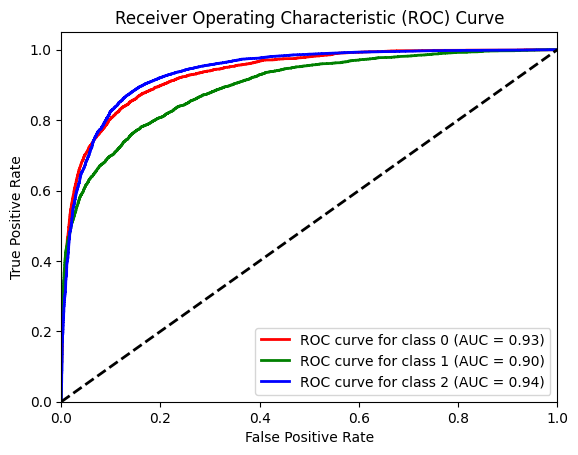

In [17]:
# evaluation
from sklearn.preprocessing import LabelEncoder, label_binarize
# Plot ROC curves for each class
num_classes = 3
false_pos_rate = dict()
true_pos_rate = dict()
roc_auc = dict()
for i in range(num_classes):
    false_pos_rate[i], true_pos_rate[i], _ = roc_curve(label_binarize(y_test, classes=[0, 1, 2])[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(false_pos_rate[i], true_pos_rate[i])

plt.figure()
colors = ['red', 'green', 'blue']
for i, color in zip(range(num_classes), colors):
    plt.plot(false_pos_rate[i], true_pos_rate[i], color=color, lw=2,
             label=f'ROC curve for class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


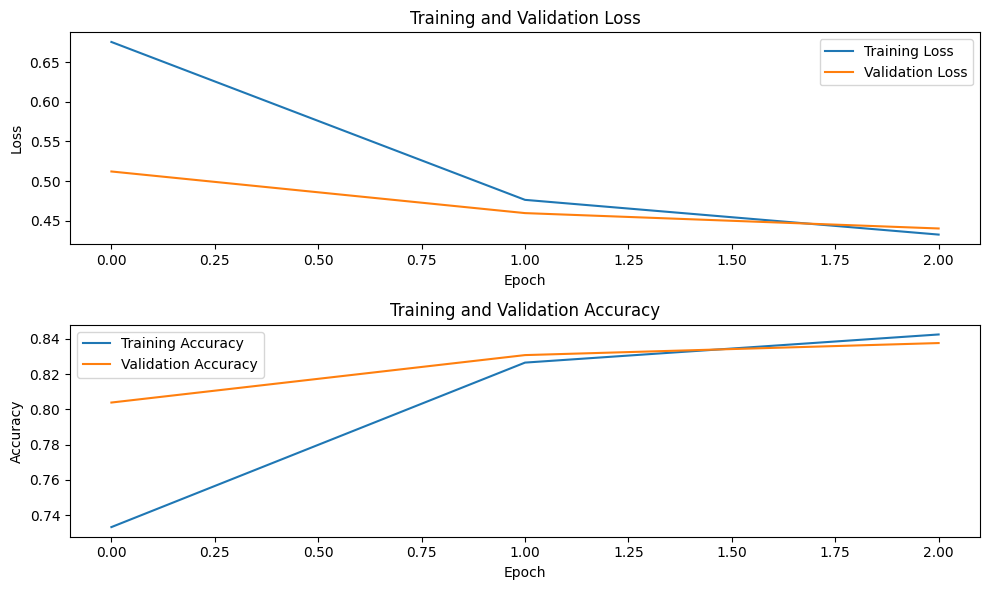

In [18]:
# Plot validation curve
def plot_validation_curve(history):
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_validation_curve(history)











706/706 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step


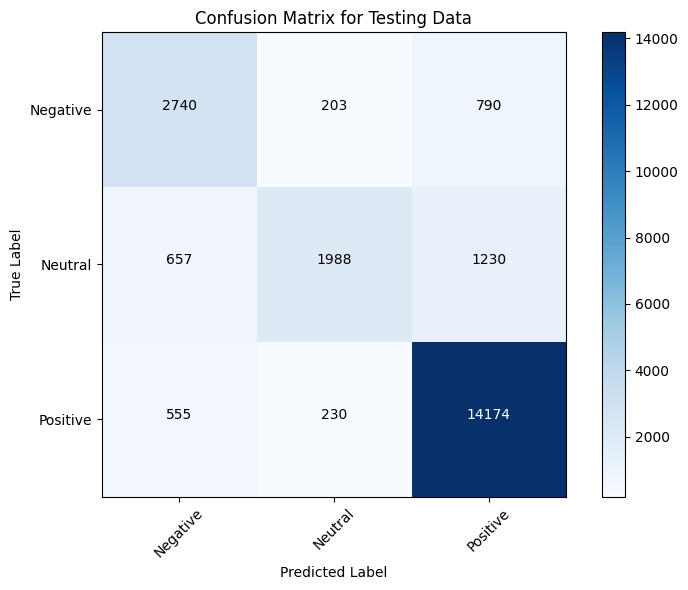

In [19]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np



# Plot confusion matrix for testing data
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)
cm_test = confusion_matrix(y_test, y_test_pred)



# Calculate confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for testing data
plt.figure(figsize=(8, 6))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Testing Data')
plt.colorbar()

tick_marks = np.arange(len(class_map))
plt.xticks(tick_marks, class_map.keys(), rotation=45)
plt.yticks(tick_marks, class_map.keys())

# Annotate each cell with the numeric value of the confusion matrix
thresh = cm_test.max() / 2.
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [33]:
model.save(r"C:\Users\dhill\VS-Code\prabh\casual_transformer_positional_model_1.h5")

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, LayerNormalization, Dropout, Dense, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define custom layers
class RelativePositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_seq_len, depth):
        super(RelativePositionalEncoding, self).__init__()
        self.depth = depth
        self.max_seq_len = max_seq_len
        self.embedding = Embedding(input_dim=2 * max_seq_len - 1, output_dim=depth)

    def call(self, x):
        batch_size, seq_len = tf.shape(x)[0], tf.shape(x)[1]
        range_vec = tf.range(seq_len)
        range_mat = tf.reshape(range_vec, (-1, 1)) - tf.reshape(range_vec, (1, -1))
        range_mat = range_mat + (self.max_seq_len - 1)
        return self.embedding(range_mat)

class CausalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, max_seq_len):
        super(CausalSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.relative_position_encoding = RelativePositionalEncoding(max_seq_len, key_dim)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        mask = tf.expand_dims(mask, 0)
        mask = tf.expand_dims(mask, 0)
        pos_encoding = self.relative_position_encoding(inputs)
        return self.attention(inputs, inputs, attention_mask=mask)

def CausalTransformerLayer(inputs, num_heads, key_dim, feedforward_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = CausalSelfAttention(num_heads, key_dim, max_seq_len)(x)
    x = Dropout(dropout)(x)
    x = x + inputs
    
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(feedforward_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + inputs

# Define model parameters
vocab_size = 5500
max_seq_len = 100
Embedding_dim = 64
num_heads = 4
feedforward_dim = 128
dropout_rate = 0.1

# Build the model
inputs = Input(shape=(max_seq_len,))
Embed_layer = Embedding(vocab_size, Embedding_dim, input_length=max_seq_len)
x = Embed_layer(inputs)

for _ in range(4):
    x = CausalTransformerLayer(x, num_heads, Embedding_dim, feedforward_dim, dropout_rate)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(3, activation='softmax')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit(x_train, y_train, epochs=1, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stopping])
train_time = time.time() - start_time


706/706 ━━━━━━━━━━━━━━━━━━━━ 241s 330ms/step - accuracy: 0.6763 - loss: 0.7987 - val_accuracy: 0.8107 - val_loss: 0.5081
Restoring model weights from the end of the best epoch: 1.


In [49]:

# Save the model in Keras format
model.save('causal_transformer_positional_model.keras')

In [55]:
import numpy as np
import tensorflow as tf
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.preprocessing import LabelEncoder

# Ensure necessary NLTK data packages are downloaded
nltk.download('punkt')
nltk.download('wordnet')

# Define constants
vocab_size = 5500
max_seq_len = 100

# Load pre-trained tokenizer
tokenizer = Tokenizer(num_words=vocab_size)

# Load pre-trained label encoder
lbl_encoder = LabelEncoder()

# Define a function to preprocess the text input
def text_preprocess(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s]', '', text) 
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(tokens)
    return ''

# Load the Keras model
model_path_keras = 'causal_transformer_positional_model.keras'
model = tf.keras.models.load_model(model_path_keras, custom_objects={
    'RelativePositionalEncoding': RelativePositionalEncoding,
    'CausalSelfAttention': CausalSelfAttention
})

# Define a function to predict sentiment
def predict_sentiment(text):
    # Preprocess the input text
    
    clean_text = text_preprocess(text)
    
    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([clean_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_seq_len)

    # Predict the sentiment
    prediction_prob = model.predict(padded_sequence)
    prediction = np.argmax(prediction_prob, axis=1)
    sentiment = lbl_encoder.inverse_transform(prediction)
    
    # Display the result
    print(f"Predicted Sentiment: {sentiment[0]}")
    return prediction_prob

# Example usage
user_input = "This is a great movie!"
prediction_prob = predict_sentiment(user_input)
print("Prediction Probabilities:")
print(prediction_prob)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_7', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 100], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}, 'registered_name': None, 'name': 'input_layer_3', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding_23', 'trainable': True, 'dtype': 'float32', 'input_dim': 5500, 'output_dim': 64, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 100]}, 'name': 'embedding_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100], 'dtype': 'float32', 'keras_history': ['input_layer_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_24', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'layer_normalization_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['embedding_23', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'CausalSelfAttention', 'config': {'num_heads': 4, 'key_dim': 64, 'max_seq_len': 100, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'CausalSelfAttention', 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'causal_self_attention_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_45', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'dropout_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['causal_self_attention_16', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_24'}, 'registered_name': 'Add', 'name': 'add_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['dropout_45', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['embedding_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_25', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'layer_normalization_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_30', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'dense_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_46', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 128]}, 'name': 'dropout_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 128], 'dtype': 'float32', 'keras_history': ['dense_30', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_31', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 128]}, 'name': 'dense_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 128], 'dtype': 'float32', 'keras_history': ['dropout_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_25'}, 'registered_name': 'Add', 'name': 'add_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['dense_31', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['embedding_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_26', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'layer_normalization_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_25', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'CausalSelfAttention', 'config': {'num_heads': 4, 'key_dim': 64, 'max_seq_len': 100, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'CausalSelfAttention', 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'causal_self_attention_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_48', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'dropout_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['causal_self_attention_17', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_26'}, 'registered_name': 'Add', 'name': 'add_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['dropout_48', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_27', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'layer_normalization_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_32', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'dense_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_49', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 128]}, 'name': 'dropout_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 128], 'dtype': 'float32', 'keras_history': ['dense_32', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_33', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 128]}, 'name': 'dense_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 128], 'dtype': 'float32', 'keras_history': ['dropout_49', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_27'}, 'registered_name': 'Add', 'name': 'add_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['dense_33', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_28', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'layer_normalization_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_27', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'CausalSelfAttention', 'config': {'num_heads': 4, 'key_dim': 64, 'max_seq_len': 100, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'CausalSelfAttention', 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'causal_self_attention_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_51', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'dropout_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['causal_self_attention_18', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_28'}, 'registered_name': 'Add', 'name': 'add_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['dropout_51', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_29', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'layer_normalization_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_34', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'dense_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_52', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 128]}, 'name': 'dropout_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 128], 'dtype': 'float32', 'keras_history': ['dense_34', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_35', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 128]}, 'name': 'dense_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 128], 'dtype': 'float32', 'keras_history': ['dropout_52', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_29'}, 'registered_name': 'Add', 'name': 'add_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['dense_35', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_30', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'layer_normalization_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_29', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'CausalSelfAttention', 'config': {'num_heads': 4, 'key_dim': 64, 'max_seq_len': 100, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'CausalSelfAttention', 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'causal_self_attention_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_54', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'dropout_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['causal_self_attention_19', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_30'}, 'registered_name': 'Add', 'name': 'add_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['dropout_54', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_31', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'layer_normalization_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_36', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'dense_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_55', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 128]}, 'name': 'dropout_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 128], 'dtype': 'float32', 'keras_history': ['dense_36', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_37', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 128]}, 'name': 'dense_37', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 128], 'dtype': 'float32', 'keras_history': ['dropout_55', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_31'}, 'registered_name': 'Add', 'name': 'add_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['dense_37', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling1D', 'config': {'name': 'global_average_pooling1d_3', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'global_average_pooling1d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['add_31', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_56', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'dropout_56', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64], 'dtype': 'float32', 'keras_history': ['global_average_pooling1d_3', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_38', 'trainable': True, 'dtype': 'float32', 'units': 20, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'dense_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64], 'dtype': 'float32', 'keras_history': ['dropout_56', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_57', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20]}, 'name': 'dropout_57', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20], 'dtype': 'float32', 'keras_history': ['dense_38', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_39', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20]}, 'name': 'dense_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20], 'dtype': 'float32', 'keras_history': ['dropout_57', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_3', 0, 0]], 'output_layers': [['dense_39', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'loss': 'sparse_categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class '__main__.CausalSelfAttention'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'CausalSelfAttention', 'config': {'num_heads': 4, 'key_dim': 64, 'max_seq_len': 100, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'CausalSelfAttention', 'build_config': {'input_shape': [None, 100, 64]}, 'name': 'causal_self_attention_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_24', 0, 0]}}], 'kwargs': {}}]}.

Exception encountered: Error when deserializing class 'CausalSelfAttention' using config={'num_heads': 4, 'key_dim': 64, 'max_seq_len': 100, 'trainable': True, 'dtype': 'float32'}.

Exception encountered: CausalSelfAttention.__init__() got an unexpected keyword argument 'trainable'